In [7]:
import time
import random
from gurobipy import Model, GRB, quicksum
import numpy as np
import pandas as pd
import os


In [8]:
cur_dir = os.getcwd()
cur_dir

'/Users/dtjgp/Learning/GreenAI/Opreation/solve'

In [9]:
# solar_data = pd.read_csv('/Users/jingsichen/Politecnico Di Torino Studenti Dropbox/Jingsi Chen/Mac/Desktop/Green AI/AI/solve/pvwatts_hourly.csv')
solar_data = pd.read_csv('pvwatts_hourly.csv')

In [10]:
# upload pvwatts_hourly.csv
G_max_solar = solar_data['AC System Output (W)'][1:8761].tolist()
G_max_solar[140:190]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 198.276,
 468.904,
 685.425,
 786.688,
 742.399,
 559.622,
 288.752,
 60.829,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 203.027,
 477.88,
 753.906,
 887.398,
 836.562,
 626.936,
 324.377,
 68.645,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

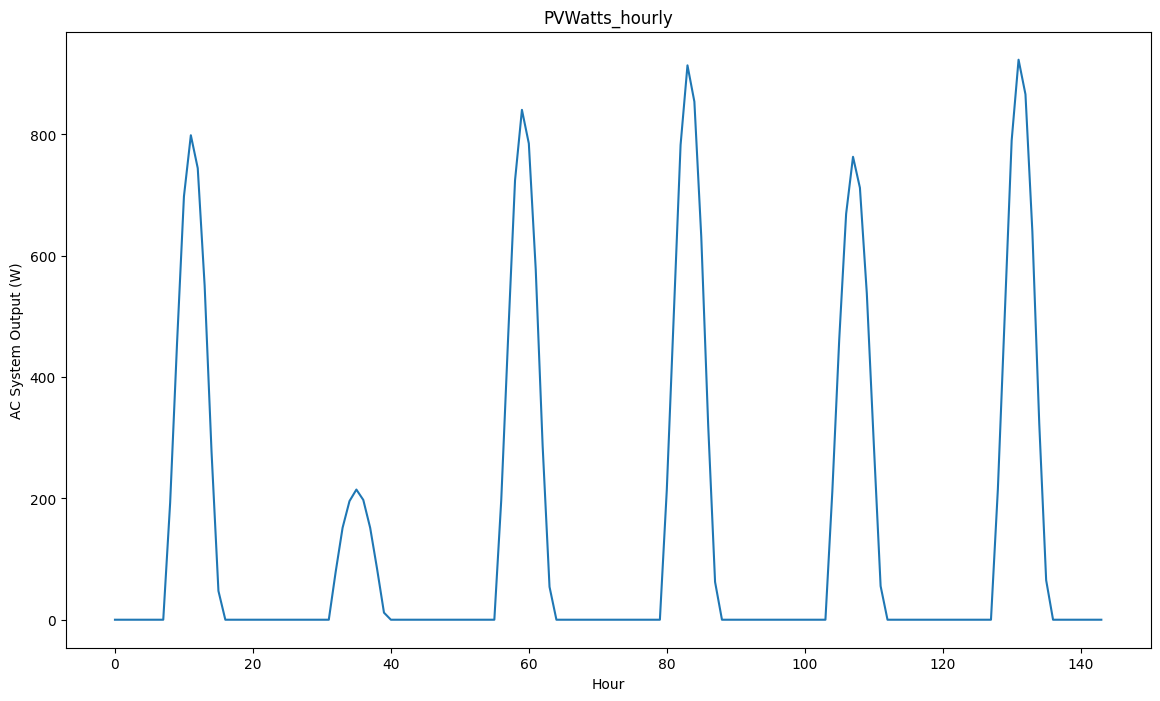

In [11]:
# 画出G_max_solar 前144个数
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.plot(G_max_solar[0:144])
plt.xlabel('Hour')
plt.ylabel('AC System Output (W)')
plt.title(f'PVWatts_hourly')
plt.show()

In [ ]:
def generate_instance():
    operations_info = {}
    # Each tuple in the list corresponds to (num_operations, power_per_operation)
    processes_details = [(32, 100), (28, 125), (26, 150), (25, 175), (24, 200), (23, 225), (22, 250)]
    # processes_details = [(16, 100), (15, 125), (14, 150), (13, 175), (12, 200), (11, 225), (10, 250)]
    for i, (num_operations, power) in enumerate(processes_details):
        # Set every operation's duration to 1 and power to the specified power
        operations = [{'power': power, 'duration': 1} for _ in range(num_operations)]
        # The maximum time for completion is set to the number of operations
        max_time = num_operations
        operations_info[i] = {'operations': operations, 'max_time': max_time}
    
    return operations_info

instance = generate_instance()
instance

In [13]:
# 创建模型
model = Model("Power_Management")

Set parameter Username
Set parameter LicenseID to value 2585013
Academic license - for non-commercial use only - expires 2025-11-14


In [14]:
start_hour = 143
Hours = 26
end_hour = start_hour + Hours
I = range(len(instance))  
F = {i: range(len(instance[i]['operations'])) for i in I} 
operations_info = {i: instance[i]['operations'] for i in I}
operation_power = {i: {k: operations_info[i][k]['power'] for k in F[i]} for i in I}
operation_time = {i: {k: operations_info[i][k]['duration'] for k in F[i]} for i in I}
process_max_time = {i: instance[i]['max_time'] for i in I}
E_max = 250  # ESD 最大容量
alpha, beta, theta = 0.9, 0.9, 0.0015  # 充放电和自放电效率
G_max_grid = 1000   # 电网最大功率
GPU_power_options = [100, 125, 150, 175, 200, 225, 250]  # GPU功率选项
# 设置电价和电网回购电价
electricity_price = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.35, 0.45, 0.45, 0.45, 0.45,
                     0.45, 0.45, 0.45, 0.45, 0.45, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.25]*30  # 每小时的电价
sell_back_price = 0.05  # 电网回购电价

In [15]:
contributions = [1/32, 1/28, 1/26, 1/25, 1/24, 1/23, 1/22]
# contributions = [1/16, 1/15, 1/14, 1/13, 1/12, 1/11, 1/10]

In [16]:
# 创建变量
# 太阳能
G_solar = model.addVars(range(start_hour, end_hour), lb=0, name="G_solar")
P_solar = model.addVars(range(start_hour, end_hour), lb=0, name="P_solar")
R_solar = model.addVars(range(start_hour, end_hour), lb=0, name="R_solar")
W_solar = model.addVars(range(start_hour, end_hour), lb=0, name="W_solar")

for t in range(start_hour, end_hour):
    G_solar[t].ub = G_max_solar[t]
    P_solar[t].ub = G_max_solar[t]
    R_solar[t].ub = G_max_solar[t]
    W_solar[t].ub = G_max_solar[t]

# 电网
G_grid = model.addVars(range(start_hour, end_hour), lb=0, ub=G_max_grid, name="G_grid")
P_grid = model.addVars(range(start_hour, end_hour), lb=0, ub=G_max_grid, name="P_grid")
R_grid = model.addVars(range(start_hour, end_hour), lb=0, ub=G_max_grid, name="R_grid")
W_grid = model.addVars(range(start_hour, end_hour), lb=0, ub=G_max_grid, name="W_grid")

# 电池
D_dc = model.addVars(range(start_hour, end_hour), lb=0, ub=E_max, name="D_dc")
D_grid = model.addVars(range(start_hour, end_hour), lb=0, ub=E_max, name="D_grid")
ESD = model.addVars(range(start_hour, end_hour+1), lb=0, ub=E_max, name="ESD")

# GPU功率
# y = model.addVars(range(start_hour, end_hour), I, {i: F[i] for i in I}, vtype=GRB.BINARY, name="y") # 操作选择变量 第t时刻第i个进程的第k个操作是否执行
y = model.addVars(range(start_hour, end_hour), I, F[0], vtype=GRB.BINARY, name="y")
gpu_power = model.addVars(range(start_hour, end_hour), lb=0, ub=max(GPU_power_options), name="gpu_power")
power_selection = model.addVars(range(start_hour, end_hour), len(GPU_power_options), vtype=GRB.BINARY, name="power_selection")

# 目标函数：最小化总电力成本
objective =  quicksum((G_grid[t] * electricity_price[t] - W_grid[t] * sell_back_price) for t in range(start_hour, end_hour))
model.setObjective(objective, sense=GRB.MINIMIZE)

In [17]:
model.addConstrs(P_solar[t] + R_solar[t] + W_solar[t] == G_solar[t] for t in range(start_hour, end_hour)) # 太阳能给出去的总功率 = data center + battery + back to grid 
model.addConstrs(P_grid[t] + R_grid[t] == G_grid[t] for t in range(start_hour, end_hour)) # 电网给出去的总功率 = data center + battery
model.addConstrs(W_solar[t] + beta * D_grid[t] == W_grid[t] for t in range(start_hour, end_hour)) # 卖回电网的功率等于太阳能卖回电网的功率加上电池卖回电网的功率
model.addConstrs(R_solar[t]+R_grid[t] <= (E_max - ESD[t]) for t in range(start_hour, end_hour)) # 电池容量限制
model.addConstrs(ESD[t] == (1-theta) * (ESD[t-1] - D_dc[t-1] - D_grid[t-1] + alpha * (R_solar[t-1] + R_grid[t-1])) for t in range(start_hour+1, end_hour+1)) # 电池容量更新
model.addConstrs(D_dc[t] + D_grid[t] <= ESD[t] for t in range(start_hour, end_hour)) # 电池放电功率不得超过电池容量
model.addConstrs(D_dc[t] + D_grid[t] >= 0 for t in range(start_hour, end_hour)) # 电池放电功率不得为负


{143: <gurobi.Constr *Awaiting Model Update*>,
 144: <gurobi.Constr *Awaiting Model Update*>,
 145: <gurobi.Constr *Awaiting Model Update*>,
 146: <gurobi.Constr *Awaiting Model Update*>,
 147: <gurobi.Constr *Awaiting Model Update*>,
 148: <gurobi.Constr *Awaiting Model Update*>,
 149: <gurobi.Constr *Awaiting Model Update*>,
 150: <gurobi.Constr *Awaiting Model Update*>,
 151: <gurobi.Constr *Awaiting Model Update*>,
 152: <gurobi.Constr *Awaiting Model Update*>,
 153: <gurobi.Constr *Awaiting Model Update*>,
 154: <gurobi.Constr *Awaiting Model Update*>,
 155: <gurobi.Constr *Awaiting Model Update*>,
 156: <gurobi.Constr *Awaiting Model Update*>,
 157: <gurobi.Constr *Awaiting Model Update*>,
 158: <gurobi.Constr *Awaiting Model Update*>,
 159: <gurobi.Constr *Awaiting Model Update*>,
 160: <gurobi.Constr *Awaiting Model Update*>,
 161: <gurobi.Constr *Awaiting Model Update*>,
 162: <gurobi.Constr *Awaiting Model Update*>,
 163: <gurobi.Constr *Awaiting Model Update*>,
 164: <gurobi

In [18]:
# 每个时间槽的job完成量变量
completion_per_slot = model.addVars(range(start_hour, end_hour), name="completion_per_slot", vtype=GRB.CONTINUOUS)

# 每个时间槽中只能执行一个operation
for t in range(start_hour, end_hour):
    model.addConstr(completion_per_slot[t] == quicksum(y[t, i, k] * contributions[i] for i in I for k in F[i]), name=f"CompletionTime_{t}")
    model.addConstr(quicksum(y[t, i, k] for i in I for k in F[i]) == 1, name=f"OneOperationAtTime_{t}")

# 定义完成率变量
model.addConstr(quicksum(completion_per_slot[t] for t in range(start_hour, end_hour)) >= 1, name="CompleteJob")


<gurobi.Constr *Awaiting Model Update*>

In [19]:
model.addConstrs((P_solar[t] + P_grid[t] + beta * D_dc[t] >= quicksum(y[t, i, k] * instance[i]['operations'][k]['power'] for i in I for k in F[i]) for t in range(start_hour, end_hour)), "PowerBalance")
model.addConstrs((P_solar[t] + P_grid[t] + beta * D_dc[t] >= gpu_power[t] for t in range(start_hour, end_hour)), "DataCenterPowerSupplyMatchesGPUPower")
model.addConstrs((quicksum(power_selection[t, j] * GPU_power_options[j] for j in range(len(GPU_power_options))) == gpu_power[t] for t in range(start_hour, end_hour)),"SelectGPUPower")
model.addConstrs((quicksum(power_selection[t, j] for j in range(len(GPU_power_options))) == 1 for t in range(start_hour, end_hour)),"OnePowerOption")

{143: <gurobi.Constr *Awaiting Model Update*>,
 144: <gurobi.Constr *Awaiting Model Update*>,
 145: <gurobi.Constr *Awaiting Model Update*>,
 146: <gurobi.Constr *Awaiting Model Update*>,
 147: <gurobi.Constr *Awaiting Model Update*>,
 148: <gurobi.Constr *Awaiting Model Update*>,
 149: <gurobi.Constr *Awaiting Model Update*>,
 150: <gurobi.Constr *Awaiting Model Update*>,
 151: <gurobi.Constr *Awaiting Model Update*>,
 152: <gurobi.Constr *Awaiting Model Update*>,
 153: <gurobi.Constr *Awaiting Model Update*>,
 154: <gurobi.Constr *Awaiting Model Update*>,
 155: <gurobi.Constr *Awaiting Model Update*>,
 156: <gurobi.Constr *Awaiting Model Update*>,
 157: <gurobi.Constr *Awaiting Model Update*>,
 158: <gurobi.Constr *Awaiting Model Update*>,
 159: <gurobi.Constr *Awaiting Model Update*>,
 160: <gurobi.Constr *Awaiting Model Update*>,
 161: <gurobi.Constr *Awaiting Model Update*>,
 162: <gurobi.Constr *Awaiting Model Update*>,
 163: <gurobi.Constr *Awaiting Model Update*>,
 164: <gurobi

In [20]:
model.addConstrs(
    (quicksum(y[t, i, k] * operation_power[i][k] for i in I for k in F[i]) <= gpu_power[t] 
     for t in range(start_hour, end_hour)),"GPUPowerLimit")

{143: <gurobi.Constr *Awaiting Model Update*>,
 144: <gurobi.Constr *Awaiting Model Update*>,
 145: <gurobi.Constr *Awaiting Model Update*>,
 146: <gurobi.Constr *Awaiting Model Update*>,
 147: <gurobi.Constr *Awaiting Model Update*>,
 148: <gurobi.Constr *Awaiting Model Update*>,
 149: <gurobi.Constr *Awaiting Model Update*>,
 150: <gurobi.Constr *Awaiting Model Update*>,
 151: <gurobi.Constr *Awaiting Model Update*>,
 152: <gurobi.Constr *Awaiting Model Update*>,
 153: <gurobi.Constr *Awaiting Model Update*>,
 154: <gurobi.Constr *Awaiting Model Update*>,
 155: <gurobi.Constr *Awaiting Model Update*>,
 156: <gurobi.Constr *Awaiting Model Update*>,
 157: <gurobi.Constr *Awaiting Model Update*>,
 158: <gurobi.Constr *Awaiting Model Update*>,
 159: <gurobi.Constr *Awaiting Model Update*>,
 160: <gurobi.Constr *Awaiting Model Update*>,
 161: <gurobi.Constr *Awaiting Model Update*>,
 162: <gurobi.Constr *Awaiting Model Update*>,
 163: <gurobi.Constr *Awaiting Model Update*>,
 164: <gurobi

In [21]:
# 初始条件和容量限制
ESD[start_hour].setAttr(GRB.Attr.LB, 0)
ESD[start_hour].setAttr(GRB.Attr.UB, 0)

In [22]:
# 求解模型
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.2.0 24C5079e)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 365 rows, 6345 columns and 19994 nonzeros
Model fingerprint: 0xf28becdf
Variable types: 339 continuous, 6006 integer (6006 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+02]
  Objective range  [5e-02, 5e-01]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 2e+02]
Presolve removed 124 rows and 5864 columns
Presolve time: 0.01s
Presolved: 241 rows, 481 columns, 1417 nonzeros
Variable types: 143 continuous, 338 integer (312 binary)

Root relaxation: objective 5.293109e+02, 182 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  529.31086    0    9          -  529.31086      -     -    0s
H    0    

In [23]:
# 输出结果
total_completion = sum(completion_per_slot[t].X for t in range(start_hour, end_hour))
minimum_cost = model.objVal
results = {}
if model.status == GRB.Status.OPTIMAL:
    # results['status'] = "Optimal Solution Found"
    # results['details'] = []
    results = {
    'status': 'Optimal Solution Found',
    'details': [],
    'total_job_completion': f"{total_completion:.2%}",  # Format as a percentage
    'minimum_cost': minimum_cost
}
    for t in range(start_hour, end_hour):
        time_details = {
            'time': t,
            'G_grid': G_grid[t].X,
            'W_grid': W_grid[t].X,
            'P_grid': P_grid[t].X,
            'R_grid': R_grid[t].X,
            'G_solar': G_solar[t].X,
            'W_solar': W_solar[t].X,
            'P_solar': P_solar[t].X,
            'R_solar': R_solar[t].X,
            'D_dc': D_dc[t].X,
            'D_grid': D_grid[t].X,
            'GPU_power': gpu_power[t].X,
            'operations': [],
            'job_completion': completion_per_slot[t].X 
       
        }
        for i in I:
            for k in range(len(operation_power[i])):
                if y[t, i, k].X > 0.5:
                    time_details['operations'].append(f"Process {i} is executed")
        results['details'].append(time_details)
else:
    results['status'] = "No Optimal Solution Found"

In [24]:
results

{'status': 'Optimal Solution Found',
 'details': [{'time': 143,
   'G_grid': 150.0,
   'W_grid': 0.0,
   'P_grid': 150.0,
   'R_grid': 0.0,
   'G_solar': 0.0,
   'W_solar': 0.0,
   'P_solar': 0.0,
   'R_solar': 0.0,
   'D_dc': 0.0,
   'D_grid': 0.0,
   'GPU_power': 150.0,
   'operations': ['Process 2 is executed'],
   'job_completion': 0.038461538461538464},
  {'time': 144,
   'G_grid': 150.0,
   'W_grid': 0.0,
   'P_grid': 150.0,
   'R_grid': 0.0,
   'G_solar': 0.0,
   'W_solar': 0.0,
   'P_solar': 0.0,
   'R_solar': 0.0,
   'D_dc': 0.0,
   'D_grid': 0.0,
   'GPU_power': 150.0,
   'operations': ['Process 2 is executed'],
   'job_completion': 0.038461538461538464},
  {'time': 145,
   'G_grid': 125.0,
   'W_grid': 0.0,
   'P_grid': 125.0,
   'R_grid': 0.0,
   'G_solar': 0.0,
   'W_solar': 0.0,
   'P_solar': 0.0,
   'R_solar': 0.0,
   'D_dc': 0.0,
   'D_grid': 0.0,
   'GPU_power': 125.0,
   'operations': ['Process 1 is executed'],
   'job_completion': 0.03571428571428571},
  {'time': 146

In [25]:
total_job_completion = results['total_job_completion']
total_job_completion

'100.12%'

In [26]:

energy_dispatch = results['details']
energy_dispatch_df = pd.DataFrame(energy_dispatch)

energy_dispatch_df['total_job_completion'] = f"{total_completion:.2%}"
energy_dispatch_df['minimum_cost'] = f"${minimum_cost:.2f}"

print(energy_dispatch_df.head(20))


    time      G_grid      W_grid    P_grid      R_grid  G_solar     W_solar  \
0    143  150.000000    0.000000  150.0000    0.000000    0.000    0.000000   
1    144  150.000000    0.000000  150.0000    0.000000    0.000    0.000000   
2    145  125.000000    0.000000  125.0000    0.000000    0.000    0.000000   
3    146  125.000000    0.000000  125.0000    0.000000    0.000    0.000000   
4    147  125.000000    0.000000  125.0000    0.000000    0.000    0.000000   
5    148  125.000000    0.000000  125.0000    0.000000    0.000    0.000000   
6    149  125.000000    0.000000  125.0000    0.000000    0.000    0.000000   
7    150  281.687612    0.000000  125.0000  156.687612    0.000    0.000000   
8    151    0.000000    0.000000    0.0000    0.000000    0.000    0.000000   
9    152    0.000000    0.000000    0.0000    0.000000  198.276    0.000000   
10   153    0.000000  218.904000    0.0000    0.000000  468.904  218.904000   
11   154    0.000000  435.425000    0.0000    0.0000

In [27]:
energy_dispatch_df.to_csv('Optimization_Results.csv', index=False)
